<a href="https://colab.research.google.com/github/GuilhermeFerracini/Machine_Learning/blob/main/Deep_Learning/RentBike_reggression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Pendencias: Ajustar hyperparametros para o modelo em questão e rodar na GPU do colab
# Import Libs
import torch
from torch import nn
from torch import optim

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn import metrics
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import os

In [2]:
# Hiperparâmetros.
args = {
    'epoch_num': 200,     # Número de épocas.
    'lr': 5e-5,           # Taxa de aprendizado.
    'weight_decay': 5e-4, # Penalidade L2 (Regularização).
    'num_workers': 2,     # Número de threads do dataloader.
    'batch_size': 20,     # Tamanho do batch.
}

# GPU or CPU
if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

cpu


In [3]:
# Pre-Visualization DataSet
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
! unzip Bike-Sharing-Dataset.zip

df = pd.read_csv('hour.csv')
print(len(df))
df.head()

--2024-03-21 18:59:25--  https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘Bike-Sharing-Dataset.zip’

Bike-Sharing-Datase     [   <=>              ] 273.43K   531KB/s    in 0.5s    

2024-03-21 18:59:27 (531 KB/s) - ‘Bike-Sharing-Dataset.zip’ saved [279992]

Archive:  Bike-Sharing-Dataset.zip
  inflating: Readme.txt              
  inflating: day.csv                 
  inflating: hour.csv                
17379


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [4]:
# Train/Test split
torch.manual_seed(1)
indices = torch.randperm(len(df)).tolist() # Randomizando seleção

train_size = int(0.8*len(df))
df_train = df.iloc[indices[:train_size]]
df_test  = df.iloc[indices[train_size:]]

print(len(df_train), len(df_test))
display(df_test.head())

df_train.to_csv('bike_train.csv',index=False)
df_test.to_csv('bike_test.csv',index=False)
!ls

13903 3476


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
12663,12664,2012-06-16,2,1,6,20,0,6,0,2,0.66,0.6212,0.47,0.1940,123,229,352
1801,1802,2011-03-20,1,0,3,18,0,0,0,1,0.38,0.3939,0.40,0.3582,58,98,156
16567,16568,2012-11-28,4,1,11,1,0,3,1,2,0.26,0.2576,0.75,0.2239,0,12,12
8817,8818,2012-01-08,1,1,1,5,0,0,0,2,0.32,0.3333,0.49,0.1045,0,2,2
2608,2609,2011-04-23,2,0,4,14,0,6,0,1,0.58,0.5455,0.78,0.3582,182,209,391


Bike-Sharing-Dataset.zip  bike_test.csv  bike_train.csv  day.csv  hour.csv  Readme.txt	sample_data


In [5]:
# DataSet Class
class RentBike(Dataset):
  def __init__(self, csv_path, scaler_feat=None, scaler_label=None):

    self.dados = pd.read_csv(csv_path).to_numpy()

  def __getitem__(self, idx):

    sample = self.dados[idx][2:14]
    label  = self.dados[idx][-1:]

    # Converte para tensor
    sample = torch.from_numpy(sample.astype(np.float32))
    label  = torch.from_numpy(label.astype(np.float32))

    return sample, label

  def __len__(self):
    return len(self.dados)

dataset = RentBike('bike_train.csv')
dado, rotulo = dataset[0]
print(rotulo)
print(dado)


tensor([373.])
tensor([ 4.0000,  1.0000, 11.0000, 19.0000,  0.0000,  4.0000,  1.0000,  1.0000,
         0.3800,  0.3939,  0.2700,  0.3582])


In [6]:
# DataLoader
train_set = RentBike('bike_train.csv')
test_set  = RentBike('bike_test.csv')

print('Tamanho do treino: ' + str(len(train_set)) + ' amostras')
print('Tamanho do teste: ' + str(len(test_set)) + ' amostras')

train_loader = DataLoader(train_set,
                          args['batch_size'],
                          num_workers=args['num_workers'],
                          shuffle=True)
test_loader = DataLoader(test_set,
                         args['batch_size'],
                         num_workers=args['num_workers'],
                         shuffle=False)

# O objeto retornado é um iterador, podendo ser utilizado para iterar em loops mas não suportando indexação.
for batch in test_loader:

  dado, rotulo = batch
  print('\n## Dimensionalidade do batch ##')
  print(dado.size(), rotulo.size()) #

  break

Tamanho do treino: 13903 amostras
Tamanho do teste: 3476 amostras

## Dimensionalidade do batch ##
torch.Size([20, 12]) torch.Size([20, 1])


In [7]:
# MLP
class MLP(nn.Module):

  def __init__(self, input_size, hidden_size, out_size):
    super(MLP, self).__init__()

    self.features = nn.Sequential(
          nn.Linear(input_size, hidden_size),
          nn.ReLU(),
          nn.Linear(hidden_size, hidden_size),
          nn.ReLU(),
    )

    self.classifier = nn.Sequential(
        nn.Linear(hidden_size, out_size),
        nn.ReLU(),
    )

  def forward(self, X):

    hidden = self.features(X)
    output = self.classifier(hidden)

    return output

input_size  = train_set[0][0].size(0) #
hidden_size = 128
out_size    = 1

net = MLP(input_size, hidden_size, out_size).to(args['device'])
print(net)

MLP(
  (features): Sequential(
    (0): Linear(in_features=12, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=True)
    (1): ReLU()
  )
)


In [8]:
# Optimization and LossFunction
criterion = nn.L1Loss().to(args['device']) # L1 or MSE
optimizer = optim.Adam(net.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

In [9]:
# Fluxo de treinamento
# Iterar nas épocas
# Iterar nos batches
# Cast dos dados no dispositivo de hardware
# Forward na rede e cálculo da loss
# Cálculo do gradiente e atualização dos pesos

def train(train_loader, net, epoch):

  # Training mode
  net.train()

  start = time.time()

  epoch_loss  = []
  for batch in train_loader:

    dado, rotulo = batch

    # Cast do dado na GPU
    dado = dado.to(args['device'])
    rotulo = rotulo.to(args['device'])

    # Forward
    ypred = net(dado)
    loss = criterion(ypred, rotulo)
    epoch_loss.append(loss.cpu().data)

    # Backpropagation
    loss.backward()
    optimizer.step()

  epoch_loss = np.asarray(epoch_loss)

  end = time.time()
  print('#################### Train ####################')
  print('Epoch %d, Loss: %.4f +/- %.4f, Time: %.2f' % (epoch, epoch_loss.mean(), epoch_loss.std(), end-start))

  return epoch_loss.mean()

In [10]:
# Fluxo de teste
def validate(test_loader, net, epoch):

  # Evaluation mode
  net.eval()

  start = time.time()

  epoch_loss  = []

  with torch.no_grad():
    for batch in test_loader:

      dado, rotulo = batch

      # Cast do dado na GPU
      dado = dado.to(args['device'])
      rotulo = rotulo.to(args['device'])

      # Forward
      ypred = net(dado)
      loss = criterion(ypred, rotulo)
      epoch_loss.append(loss.cpu().data)

  epoch_loss = np.asarray(epoch_loss)

  end = time.time()
  print('********** Validate **********')
  print('Epoch %d, Loss: %.4f +/- %.4f, Time: %.2f\n' % (epoch, epoch_loss.mean(), epoch_loss.std(), end-start))

  return epoch_loss.mean()

In [11]:
# Iterando na epoca: Train e Test
train_losses, test_losses = [], []
for epoch in range(args['epoch_num']):

  # Train
  train_losses.append(train(train_loader, net, epoch))

  # Validate
  test_losses.append(validate(test_loader, net, epoch))

#################### Train ####################
Epoch 0, Loss: 164.3138 +/- 42.0975, Time: 7.28
********** Validate **********
Epoch 0, Loss: 125.7965 +/- 30.3890, Time: 0.75

#################### Train ####################
Epoch 1, Loss: 130.6107 +/- 25.6430, Time: 3.80
********** Validate **********
Epoch 1, Loss: 126.6351 +/- 24.3811, Time: 0.67

#################### Train ####################
Epoch 2, Loss: 122.8896 +/- 30.2196, Time: 3.25
********** Validate **********
Epoch 2, Loss: 125.2943 +/- 31.5335, Time: 0.55

#################### Train ####################
Epoch 3, Loss: 120.4436 +/- 31.0856, Time: 3.29
********** Validate **********
Epoch 3, Loss: 117.2515 +/- 26.3097, Time: 0.53

#################### Train ####################
Epoch 4, Loss: 118.8115 +/- 24.6739, Time: 4.22
********** Validate **********
Epoch 4, Loss: 114.5222 +/- 28.4489, Time: 0.64

#################### Train ####################
Epoch 5, Loss: 118.3620 +/- 31.7777, Time: 3.40
********** Validate ****

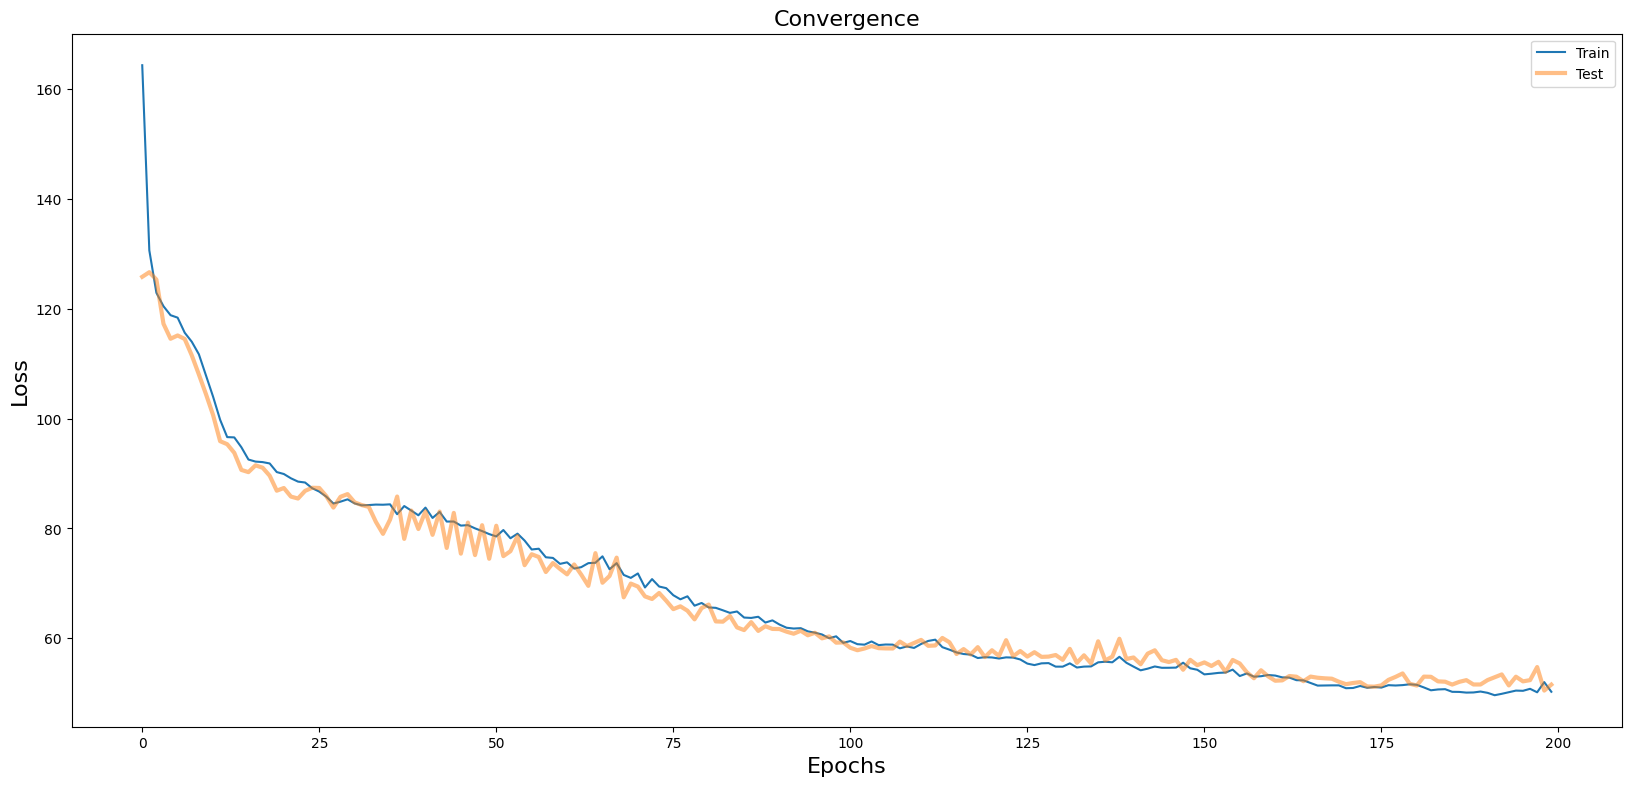

In [12]:
# Convergencia
plt.figure(figsize=(20, 9))
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test', linewidth=3, alpha=0.5)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Convergence', fontsize=16)
plt.legend()
plt.show()